

# SOLAR POWER FORECASTING

This is a brief notebook that will showcase a haw to read the half-hourly data in python, and how to aggreate that
to daily data and weekly data.


We start by preparing the environment and loading some packages

In [2]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## Data: Solar Power

Read the dataset specifying which column has the time information

In [4]:
data = pd.read_csv('solar_halfhour.csv', index_col='datetime', parse_dates=['datetime'], dayfirst=True)
data.tail()

,Customer,value
datetime,,
2013-06-30 21:30:00+00:00,4,0.183
2013-06-30 22:00:00+00:00,4,0.134
2013-06-30 22:30:00+00:00,4,0.137
2013-06-30 23:00:00+00:00,4,0.140
2013-06-30 23:30:00+00:00,4,0.112


In [7]:
data.index

DatetimeIndex(['2010-07-01 00:00:00+00:00', '2010-07-01 00:30:00+00:00',
               '2010-07-01 01:00:00+00:00', '2010-07-01 01:30:00+00:00',
               '2010-07-01 02:00:00+00:00', '2010-07-01 02:30:00+00:00',
               '2010-07-01 03:00:00+00:00', '2010-07-01 03:30:00+00:00',
               '2010-07-01 04:00:00+00:00', '2010-07-01 04:30:00+00:00',
               ...
               '2013-06-30 19:00:00+00:00', '2013-06-30 19:30:00+00:00',
               '2013-06-30 20:00:00+00:00', '2013-06-30 20:30:00+00:00',
               '2013-06-30 21:00:00+00:00', '2013-06-30 21:30:00+00:00',
               '2013-06-30 22:00:00+00:00', '2013-06-30 22:30:00+00:00',
               '2013-06-30 23:00:00+00:00', '2013-06-30 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=206544, freq=None)

We will illutrate the processing using one of the Customers, so we subset the dataframe to a single column and copy from the results to create an isolated object.

In [5]:
y = data[data['Customer']==1]['value'].copy()
y.index = y.index.to_period(freq='30min')

ts = y
ts

datetime
2010-07-01 00:00    0.125
2010-07-01 00:30    0.303
2010-07-01 01:00    0.471
2010-07-01 01:30    0.083
2010-07-01 02:00    0.121
                    ...  
2013-06-30 21:30    0.260
2013-06-30 22:00    0.274
2013-06-30 22:30    0.509
2013-06-30 23:00    0.166
2013-06-30 23:30    0.861
Freq: 30T, Name: value, Length: 52608, dtype: float64

We will try some holtwinters fitting, assuming a freq of 48 since it is half hourly data, and the sun seems to have a daily cycle. In the full assignment, you should double check that assumption!

In [29]:
ts.index

PeriodIndex(['2010-07-01 00:00', '2010-07-01 00:30', '2010-07-01 01:00',
             '2010-07-01 01:30', '2010-07-01 02:00', '2010-07-01 02:30',
             '2010-07-01 03:00', '2010-07-01 03:30', '2010-07-01 04:00',
             '2010-07-01 04:30',
             ...
             '2013-06-30 19:00', '2013-06-30 19:30', '2013-06-30 20:00',
             '2013-06-30 20:30', '2013-06-30 21:00', '2013-06-30 21:30',
             '2013-06-30 22:00', '2013-06-30 22:30', '2013-06-30 23:00',
             '2013-06-30 23:30'],
            dtype='period[30T]', name='datetime', length=52608)

In [6]:
import forecast
holt = forecast.holtwinters(ts, m=48)
holt.fit()
holt.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.292 (0.004)
 beta  (trend)    0.000 (0.003)
 delta (seasonal) 0.192 (0.002)
 
 In-sample fit:
 MSE               0.052
 RMSE              0.229
 Log-likelihood    2919.680
 AIC               -5831.360
 BIC               -5795.877


We will plot the in-sample smoothing vs the actual data, for exploratory reasons. Note that this specific plot is not a 'must do' for the assignment.

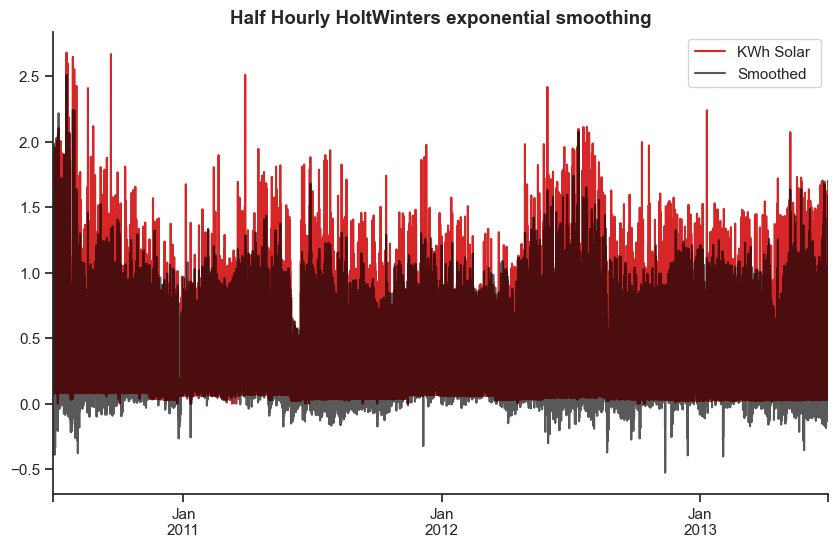

In [7]:
smoothed=pd.Series(holt.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

ts.plot(color='#D62728', label='KWh Solar ')
smoothed.plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Half Hourly HoltWinters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

The frequency is so high that we can barely seen any detail, we will focus on the last few observations

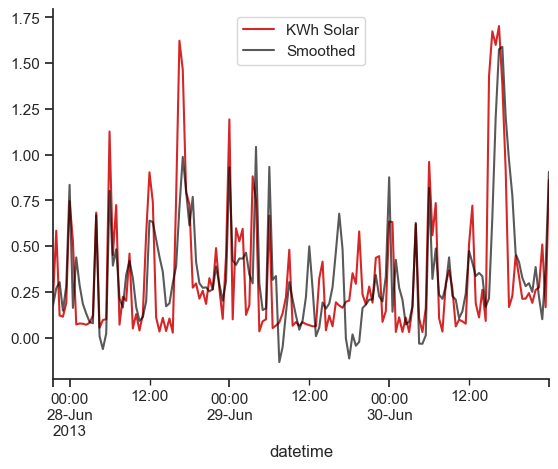

In [8]:
ts[-150:].plot(color='#D62728', label='KWh Solar')
smoothed[-150:].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'HoltWinters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Decomposition plot

To use the standard decomposition plot shown in Tutorial 10, we will need to modify
the indexing. We will create acopy of the time series just for the decomposition, so it does not
affect the other processing. Also, there might be other packages that perform the decompositon
without requiring this index alteration. We will try a period of 48, for the halh hourly.
We also need to shorten the time series a bit, otherwise, it will pack too much info in the plot and we will
not be able to see much.

You can try changing the period to other values, and compare the results. You can plot less data to get a more clear view.


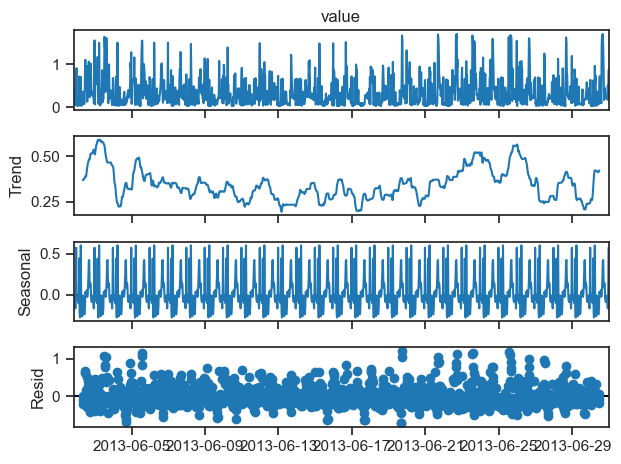

In [9]:
import statsmodels.tsa.seasonal

ts_dec = ts.copy()
ts_dec.index = ts_dec.index.to_timestamp()

decomposition = statsmodels.tsa.seasonal.seasonal_decompose(ts_dec[-1400:], period = 48)

decomposition.plot()
plt.show()

Lets forecast the next 48 half hours, the next day, and plot some intervals.
We will show the last two days of the actual data as reference

In [28]:
ts.index

PeriodIndex(['2010-07-01 00:00', '2010-07-01 00:30', '2010-07-01 01:00',
             '2010-07-01 01:30', '2010-07-01 02:00', '2010-07-01 02:30',
             '2010-07-01 03:00', '2010-07-01 03:30', '2010-07-01 04:00',
             '2010-07-01 04:30',
             ...
             '2013-06-30 19:00', '2013-06-30 19:30', '2013-06-30 20:00',
             '2013-06-30 20:30', '2013-06-30 21:00', '2013-06-30 21:30',
             '2013-06-30 22:00', '2013-06-30 22:30', '2013-06-30 23:00',
             '2013-06-30 23:30'],
            dtype='period[30T]', name='datetime', length=52608)

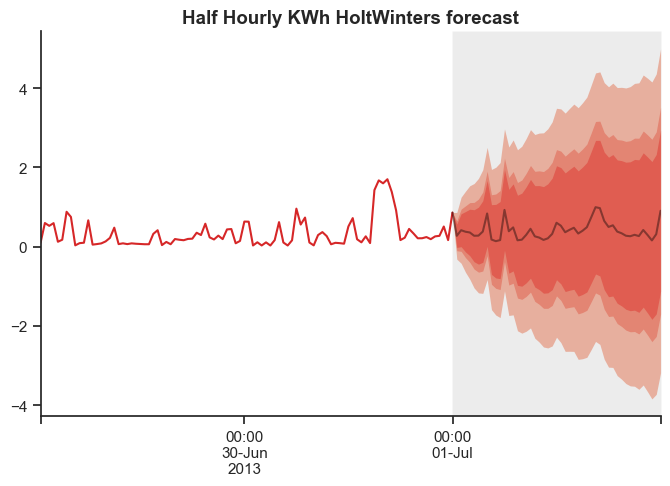

In [27]:
h=48

test=pd.period_range(start=ts.index[-1]+1, periods=h, freq='30min')

pred=pd.Series(holt.forecast(h), index=test)

intv1=pd.DataFrame(holt.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(holt.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(holt.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(ts[-96:], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Half Hourly KWh HoltWinters forecast', fontsize=13.5, fontweight='bold')

sns.despine()
plt.show()



# Aggregating the time series to Daily Frequency

Aggregation can be done with the pandas `resample` method. We need to pass the new frequency ('D' for Daily) and specify the function for aggregation. We use mean, but we could have used other such as the sum, depends on the context.

Check the data for sanity, it seems to show daily data. Note that the aggregation will induce be some bias in the days that have not been fully oberved, for those days that do not have the full cycle observed.

In [11]:
ts_day = ts.resample('D').mean()

In [12]:
ts_day.tail(5)

datetime
2013-06-26    0.465958
2013-06-27    0.242417
2013-06-28    0.372042
2013-06-29    0.249729
2013-06-30    0.424146
Freq: D, Name: value, dtype: float64

We will fit a HoltWinters, note that the period is chose arbitrarily to 12, again you need to check this and other alternative periods (and other models). What would be the period, if any, for this series?

In [13]:
import forecast
holt_day = forecast.holtwinters(ts_day, m=12)
holt_day.fit()
holt_day.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.207 (0.025)
 beta  (trend)    0.000 (0.031)
 delta (seasonal) 0.166 (0.018)
 
 In-sample fit:
 MSE               0.006
 RMSE              0.079
 Log-likelihood    1231.299
 AIC               -2454.597
 BIC               -2434.600


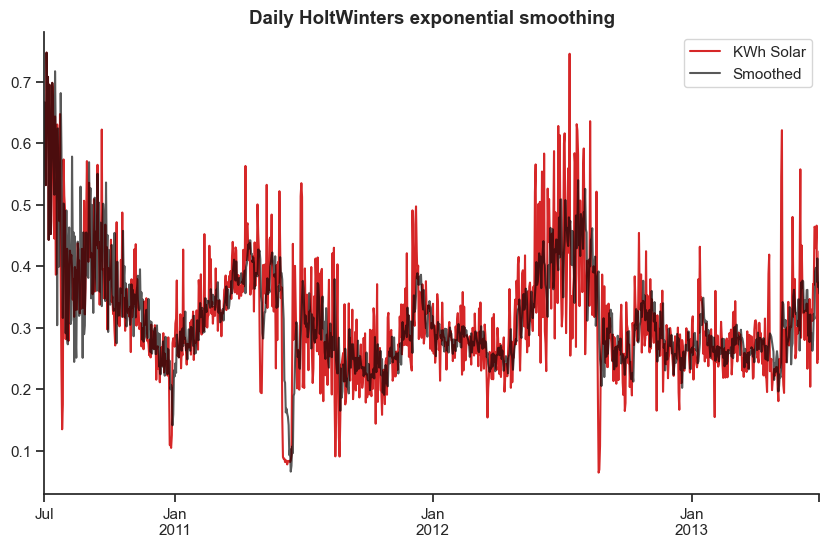

In [14]:
smoothed=pd.Series(holt_day.smooth(), index=ts_day.index)

fig, ax= plt.subplots(figsize=(10,6))

ts_day.plot(color='#D62728', label='KWh Solar')
smoothed.plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Daily HoltWinters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

We will forecast the next 28 days, the code is very similar to the half hourly, we change the fequency in the series that indicates the test range period. We will show the last year as actual data
This is a candidate for refactoring in a single function :)

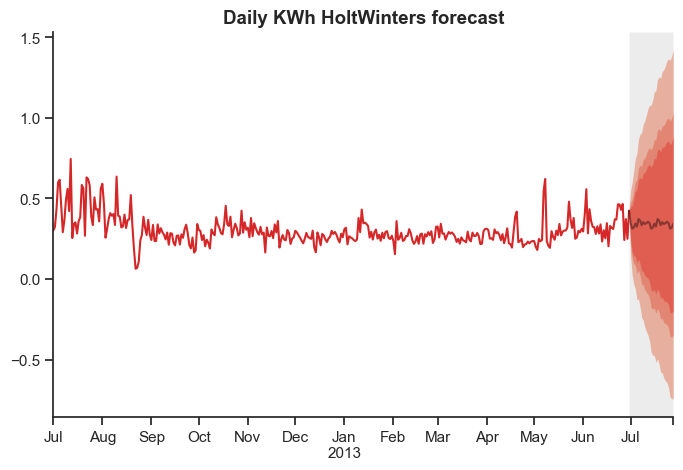

In [15]:
h=28


test=pd.period_range(start=ts_day.index[-1]+1, periods=h, freq='D')

pred=pd.Series(holt_day.forecast(h), index=test)

intv1=pd.DataFrame(holt_day.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(holt_day.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(holt_day.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(ts_day[-365:], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Daily KWh HoltWinters forecast', fontsize=13.5, fontweight='bold')

sns.despine()
plt.show()

For the sake of illutration, we will fit an autoarima with period 7, to check .
Maybe since the series is Daily, a period of 7 days might be suitable...

In [16]:
import pmdarima as pm

model_auto = pm.auto_arima(ts_day, seasonal=True, m=7)


In [26]:
ts_day

datetime
2010-07-01    0.666333
2010-07-02    0.565958
2010-07-03    0.531792
2010-07-04    0.747354
2010-07-05    0.651625
                ...   
2013-06-26    0.465958
2013-06-27    0.242417
2013-06-28    0.372042
2013-06-29    0.249729
2013-06-30    0.424146
Freq: D, Name: value, Length: 1096, dtype: float64

In [17]:
model_auto

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

We will create the intervals, note that the intervals will be much narrow than those of the exponential smoothing,
this is because autoarima produces the confidence intervals, not the prediction intervals. The confidence intervals are for the 'mean' of the
predictive distribution, not the observations. For technical reasons, using these would be OK as long as we notify that
this is what the model is doing.

In [18]:
probpred_99 = model_auto.predict(n_periods = h, return_conf_int=True, alpha=0.01)
probpred_90 = model_auto.predict(n_periods = h, return_conf_int=True, alpha=0.1)
probpred_80 = model_auto.predict(n_periods = h, return_conf_int=True, alpha=0.2)

In [19]:
pred=pd.Series(probpred_99[0], index=test)

int_auto_v1=pd.DataFrame(probpred_80[1], index=test)
int_auto_v2=pd.DataFrame(probpred_90[1], index=test)
int_auto_v3=pd.DataFrame(probpred_99[1], index=test)

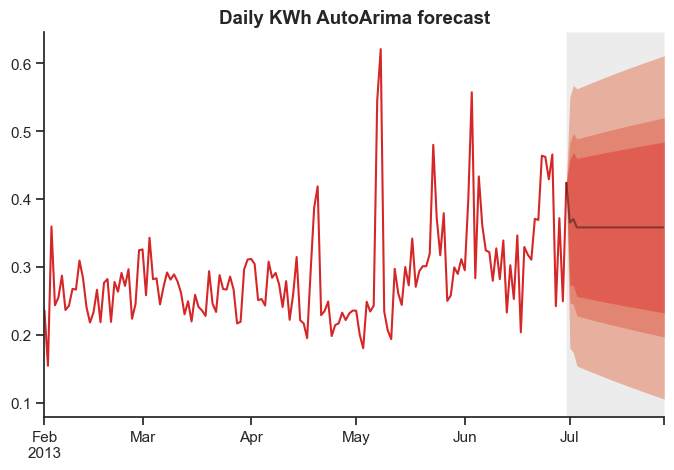

In [20]:

fig, ax = forecast.fanchart(ts_day[-150:], pred, int_auto_v1, int_auto_v2, int_auto_v3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Daily KWh AutoArima forecast', fontsize=13.5, fontweight='bold')

sns.despine()
plt.show()


# Aggregation to Monthly

Aggregation proceeds similar, using 'M' as the code for monthly aggregation. Printing the results seems OK.

In [21]:
ts_month = ts.resample('M').mean()

In [22]:
ts_month.tail(5)

datetime
2013-02    0.260676
2013-03    0.266823
2013-04    0.261381
2013-05    0.300304
2013-06    0.345168
Freq: M, Name: value, dtype: float64

In [23]:

holt_month = forecast.holtwinters(ts_month, m=12)
holt_month.fit()
holt_month.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.052 (0.087)
 beta  (trend)    0.000 (0.076)
 delta (seasonal) 0.543 (0.170)
 
 In-sample fit:
 MSE               0.010
 RMSE              0.099
 Log-likelihood    32.284
 AIC               -56.567
 BIC               -50.233


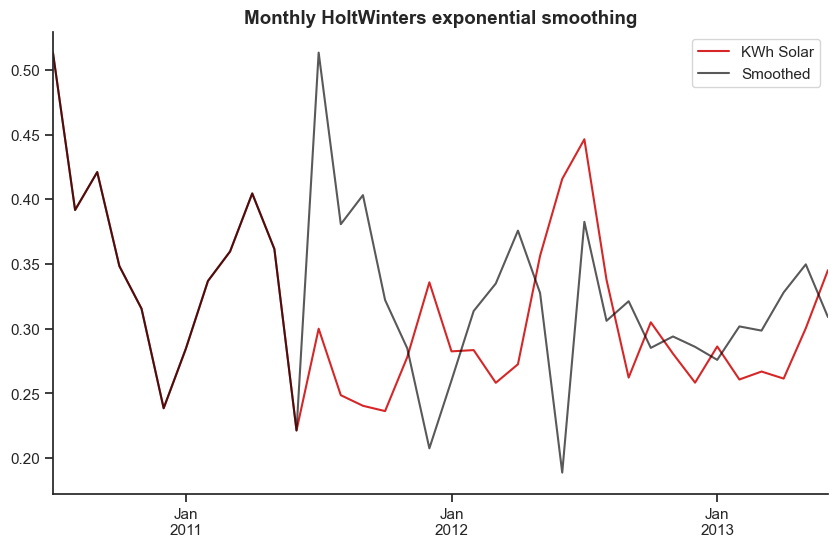

In [24]:
smoothed=pd.Series(holt_month.smooth(), index=ts_month.index)

fig, ax= plt.subplots(figsize=(10,6))

ts_month.plot(color='#D62728', label='KWh Solar')
smoothed.plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Monthly HoltWinters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

Forecasting would proceed analogously to other levels of aggregation...